# AF2 predictions benchmark 

In [352]:
import json
import os
import pandas as pd
import glob
results_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"

In [353]:
def get_plddt(results_dir, dataset):
    colabfold_dir = results_dir+dataset+"/structures/colabfold_header/"
    plddt_summary = pd.DataFrame()
    for fam in os.listdir(colabfold_dir):
        fam_dir = os.path.join(colabfold_dir,fam)
        for f in os.listdir(fam_dir):
            if f.endswith('plddt.eval'):
                plddts = pd.read_csv(os.path.join(fam_dir,f), sep = "\s+", header = None)
                plddts = plddts.set_axis(["sequence", "plddt"], axis=1)
                plddts["name"] = fam
                plddts["benchmarking_dataset"] = dataset
                
                plddt_summary = pd.concat([plddt_summary, plddts])
    plddt_summary[["family","tree_method", "bucket"]] = plddt_summary.name.str.split(".", expand=True)
    return(plddt_summary)

In [354]:
# Extract plddt for each sequence in the family
af2_homfam = get_plddt(results_dir, "homfam")
af2_homfam.head(2)

,sequence,plddt,name,benchmarking_dataset,family,tree_method,bucket
0,1bbi,71.7192,bowman.FAMSA-medoid.100,homfam,bowman,FAMSA-medoid,100
1,1pbia,74.0113,bowman.FAMSA-medoid.100,homfam,bowman,FAMSA-medoid,100


In [355]:
# Summarize plddt family-wise
af2_homfam_summary = af2_homfam.groupby(['family','tree_method',"benchmarking_dataset"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "tree_method", "benchmarking_dataset", "plddt_mean", "plddt_min", "plddt_max"], axis=1)
af2_homfam_summary.head(2)

,family,tree_method,benchmarking_dataset,plddt_mean,plddt_min,plddt_max
0,bowman,FAMSA-medoid,homfam,58.022794,44.7605,74.0113
1,rnasemam,FAMSA-medoid,homfam,78.333132,57.8495,84.7626


In [356]:
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
summary_homfam_exthomfam.head(2)
stats_af2 = pd.merge(af2_homfam_summary, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stats_af2

,family,tree_method,benchmarking_dataset,plddt_mean,plddt_min,plddt_max,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
0,bowman,FAMSA-medoid,homfam,58.022794,44.7605,74.0113,combined,499,26.144289,14,71,bowman,small,1.002004
1,rnasemam,FAMSA-medoid,homfam,78.333132,57.8495,84.7626,combined,498,120.072289,62,140,rnasemam,small,1.204819
2,seatoxin,FAMSA-medoid,homfam,64.221655,55.1243,71.2845,combined,93,43.634409,34,50,seatoxin,small,5.376344
3,toxin,FAMSA-medoid,homfam,74.358672,51.3293,79.7002,combined,508,62.311024,30,77,toxin,small,3.937008


## Store files 

In [357]:
af2_homfam.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_af2.csv"), index = False)
af2_homfam_summary.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "03_summary_af2_grouped.csv"), index = False)

# Visualize 

### How well does AF2 perform on the sequences in the families in the different datasets

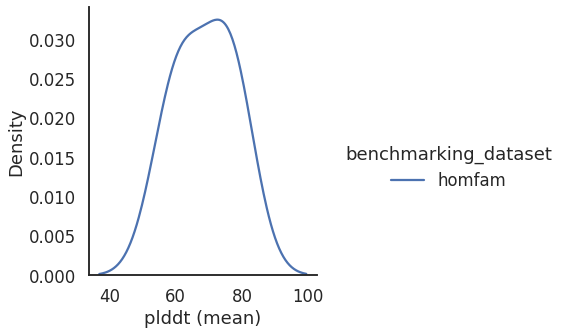

In [358]:
# Plot AF2 plddts summaries across families 
af2_homfam_summary
sns.set_theme(style="white")
sns.set_context("talk")
ax = sns.displot(af2_homfam_summary, x="plddt_mean", hue = "benchmarking_dataset", kind="kde")
ax.set(xlabel='plddt (mean)')

In [195]:
stats_af2

,family,tree_method,benchmarking_dataset,plddt_mean,plddt_min,plddt_max,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
0,bowman,FAMSA-medoid,homfam,58.037347,44.7605,74.0113,combined,499,26.144289,14,71,bowman,small,1.002004
1,seatoxin,FAMSA-medoid,homfam,64.221655,55.1243,71.2845,combined,93,43.634409,34,50,seatoxin,small,5.376344


LinAlgError: 2-th leading minor of the array is not positive definite

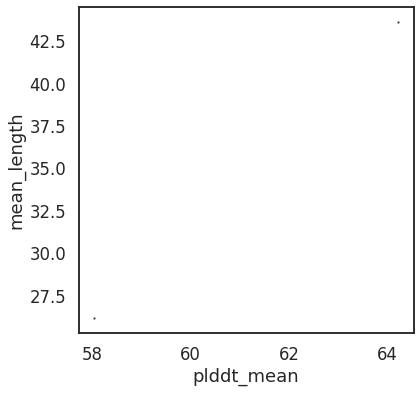

In [302]:
from Bio import SeqIO
seqs_dir="/home/luisasantus/Desktop/crg_cluster/data/structural_regression/"

def get_seq_lengths(seqs_dir, dataset, family):
    seqs_dir = os.path.join(*list([seqs_dir,dataset,"combinedSeqs"]))
    f = os.path.join(*list([seqs_dir,family+ ".fa"]))
    fasta_sequences = SeqIO.parse(open(f),'fasta')
    summary = pd.DataFrame()
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        l = len(sequence)
        name = name.replace("/", "_")
        entry = pd.DataFrame([{"family": family,
                                "sequence": name,
                                "sequence length": l,
                                "benchmarking_dataset": dataset}])
        summary = pd.concat([summary,entry], ignore_index=True)
    return(summary)

In [360]:
# Get summary
summary_lengths = pd.DataFrame()
for family in stats_af2.family:
    summary_fam = get_seq_lengths(seqs_dir, "homfam", family)
    summary_lengths = pd.concat([summary_lengths,summary_fam])

In [361]:
af2_sequence_summary = pd.merge(af2_homfam, summary_lengths, on =["family","sequence","benchmarking_dataset"])

In [362]:
af2_sequence_summary

,sequence,plddt,name,benchmarking_dataset,family,tree_method,bucket,sequence length
0,1bbi,71.7192,bowman.FAMSA-medoid.100,homfam,bowman,FAMSA-medoid,100,71
1,1bbi,71.7192,bowman.FAMSA-medoid.50,homfam,bowman,FAMSA-medoid,50,71
2,1pbia,74.0113,bowman.FAMSA-medoid.100,homfam,bowman,FAMSA-medoid,100,68
3,1pbia,74.0113,bowman.FAMSA-medoid.50,homfam,bowman,FAMSA-medoid,50,68
4,1pi2,71.8073,bowman.FAMSA-medoid.100,homfam,bowman,FAMSA-medoid,100,61
...,...,...,...,...,...,...,...,...
338,TXH2_ANTS7_3-45,65.0115,seatoxin.FAMSA-medoid.100,homfam,seatoxin,FAMSA-medoid,100,43
339,TXH7_ANTS7_3-45,63.2193,seatoxin.FAMSA-medoid.100,homfam,seatoxin,FAMSA-medoid,100,43
340,TXH8_ANTS7_3-45,66.8347,seatoxin.FAMSA-medoid.100,homfam,seatoxin,FAMSA-medoid,100,43
341,TXNA_CONGI_3-45,65.7949,seatoxin.FAMSA-medoid.100,homfam,seatoxin,FAMSA-medoid,100,43


In [363]:
summary_lengths

,family,sequence,sequence length,benchmarking_dataset
0,bowman,A0JKC9_9FABA_56-81,26,homfam
1,bowman,C5Y7Y4_SORBI_31-57,27,homfam
2,bowman,Q84X87_DOLBI_72-96,25,homfam
3,bowman,Q39806_SOYBN_4-28,25,homfam
4,bowman,B2RG94_9FABA_83-107,25,homfam
...,...,...,...,...
503,toxin,A7X3T6_THRJA_24-92,69,homfam
504,toxin,CX2_NAJME_1-61,61,homfam
505,toxin,D2VQS4_NAEGR_40-107,68,homfam
506,toxin,TS931_DENAN_1-63,63,homfam


[Text(0, 0.5, 'sequence length')]

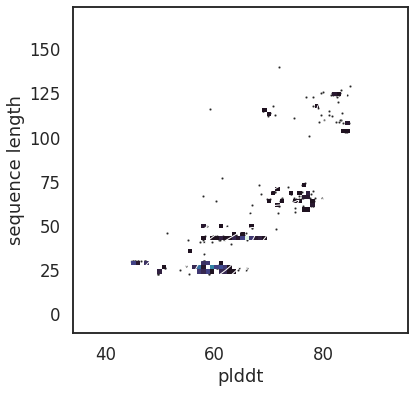

In [365]:
# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
x=af2_sequence_summary.plddt
y=af2_sequence_summary["sequence length"]
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)
ax.set(ylabel='sequence length')

193

['n: 343']


Text(1, 1, "['n: 343']")

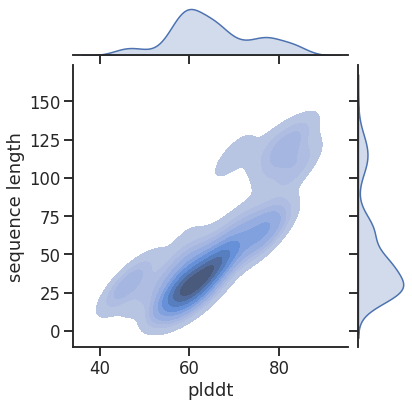

In [368]:
sns.set_theme(style="ticks")
sns.set_context("talk")


sns.jointplot(
    data=af2_sequence_summary,  fill=True, color = "red", legend = False, 
    x="plddt", y="sequence length", hue="benchmarking_dataset",
    kind="kde",
)

nobs = af2_sequence_summary['sequence'].value_counts().sum()
nobs = ["n: " + str(nobs)]
print(nobs)
# Add it to the plot
ax.text(1,1,nobs,horizontalalignment='center',size='small',color='red')
